In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

data = pd.read_csv('./data.csv') # Load dataset
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [3]:
print(len(data), "before")
data.drop_duplicates(inplace=True) # Drop duplicates
data.dropna(inplace=True) # Handle missing values (if any)
print(len(data), "after")

5842 before
5836 after


In [4]:
# One hot encoding of the target variable
encoder = LabelEncoder()
labels = encoder.fit_transform(data.Sentiment)
print(labels)
print(encoder.classes_)

[2 0 2 ... 1 1 2]
['negative' 'neutral' 'positive']


In [5]:
# Configuration of the Model and Hyperparameters
model_name = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)
hyperparameter = {
    'max_len' : 50,
    'batch_size' : 16,
    'device' : torch.device('cuda'),
    'lr_rate' : 2e-5,
    'epochs' : 10,
    'num_classes' : 3,
}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# Train, val, test split (80,10,10)
X_train, X_val_test, y_train, y_val_test = train_test_split(data.Sentence.values, labels, test_size=.2, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5, random_state=random_seed)

In [7]:
# Custom Dataset class handling the tokenization
class CustomDataset(Dataset):
    def __init__(self, data, targets, tokenizer, max_len):
        self.data = data  # Df containing filepaths and labels of imgs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = self.data[index]
        encoding = self.tokenizer.encode_plus(sentence,
                                              max_length=self.max_len,
                                              add_special_tokens=True,
                                              padding='max_length',
                                              truncation=True,
                                              return_attention_mask=True,
                                              return_token_type_ids=False,
                                              return_tensors='pt')
        
        return {
            'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
            'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
            'targets': torch.tensor(self.targets[index],dtype=torch.long)
        }

In [8]:
train_dataset = CustomDataset(X_train, y_train, tokenizer, hyperparameter['max_len'])
train_loader = DataLoader(train_dataset,
                             batch_size = hyperparameter['batch_size'],
                             num_workers = 2)

val_dataset = CustomDataset(X_val, y_val, tokenizer, hyperparameter['max_len'])
val_loader = DataLoader(val_dataset,
                             batch_size = hyperparameter['batch_size'],
                             num_workers = 2)

test_dataset = CustomDataset(X_test, y_test, tokenizer, hyperparameter['max_len'])
test_loader = DataLoader(test_dataset,
                        batch_size = hyperparameter['batch_size'],
                        num_workers = 2)

In [9]:
# Classifier with adapted classification head
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier, self).__init__()
        self.model = BertModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=.3)
        self.out = nn.Linear(self.model.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input_ids, attention_mask):
        _, pooled_output = self.model(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [10]:
class Metrics(object):
    '''Class to compute metric averages'''
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss, self.acc = 0, 0
        self.avg_loss, self.avg_acc = 0, 0
        self.sum_loss, self.sum_acc = 0, 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss, self.avg_acc = self.sum_loss / self.count, self.sum_acc / self.count
        
class Log(object):
    '''Class to record loss & accuracy'''
    def __init__(self):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
    def append(self, train, val):
        self.train_loss.append(train.avg_loss)
        self.train_accuracy.append(train.avg_acc)
        self.val_loss.append(val.avg_loss)
        self.val_accuracy.append(val.avg_acc)

In [11]:
class Trainer:

    def __init__(self,
                 model,  # Model to be trained.
                 crit,  # Loss function
                 optim=None,  # Optimizer
                 train_dl=None,  # Training data set
                 val_test_dl=None,  # Validation (or test) data set
                 device='cuda',  # Whether to use the GPU
                 early_stopping_patience=-1,  # The patience for early stopping
                 scheduler=None):
        self._model = model
        self._crit = crit
        self._optim = optim
        self._train_dl = train_dl
        self._val_test_dl = val_test_dl
        self._device = device
        self._early_stopping_patience = early_stopping_patience
        self.checkpoint = None
        self.scheduler = scheduler

        self._model = self._model.to(device)
        self._crit = self._crit.to(device)

    def save_checkpoint(self):
        '''Overwriting checkpoint whenever validation loss is improved'''
        torch.save(self._model.state_dict(), f'best.pth')

    def restore_best_checkpoint(self):
        '''Restore model weights of epoch with best validation loss'''
        self._model.load_state_dict(torch.load('./best.pth'))

    def train_step(self, input_ids, attention_mask, targets):

        # Reset gradients to zero
        self._optim.zero_grad()

        # Forward pass: compute predicted y
        y_hat = self._model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(y_hat, dim=1)
        
        # Compute loss
        loss = self._crit(y_hat, targets)
        
        # Calculate Metric (accuracy)
        acc = self.metric_calc(preds, targets)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update model parameters
        self._optim.step()

        # Return loss and predicted y
        return loss, y_hat, acc

    def val_test_step(self, input_ids, attention_mask, targets):

        # Forward pass: compute predicted y
        y_hat = self._model(input_ids=input_ids, attention_mask=attention_mask)

        # Compute validation loss
        loss = self._crit(y_hat, targets)
        preds = torch.argmax(y_hat, dim=1)
        
        # Compute Metric (accuracy)
        acc = self.metric_calc(preds, targets)

        # Return validation loss and predicted y
        return loss, y_hat, acc

    def train_epoch(self):
    
        # Set training mode
        self._model.train()
        
        metrics = Metrics()

        # Iterate over batches in the training set
        for i, batch in enumerate(self._train_dl):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            targets = batch['targets']

            # Move tensors to GPU if available
            input_ids = input_ids.to(self._device, non_blocking=True).long()
            attention_mask = attention_mask.to(self._device, non_blocking=True).long()
            targets = targets.to(self._device, non_blocking=True).long()

            loss, preds, acc = self.train_step(input_ids = input_ids,
                                          attention_mask = attention_mask,
                                          targets = targets)

            metrics.update(loss.item(), acc, hyperparameter["batch_size"])

        print(f"\tTraining Loss: {metrics.avg_loss}, Training Accuracy: {metrics.avg_acc}")

        return metrics

    def val_test(self):

        # Set evaluation mode
        self._model.eval()
        
        metrics = Metrics()

        # Disable gradient computation
        with torch.no_grad():

            # Iterate over batches in the training set
            for i, batch in enumerate(self._val_test_dl):
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                targets = batch['targets']

                input_ids = input_ids.to(self._device, non_blocking=True).long()
                attention_mask = attention_mask.to(self._device, non_blocking=True).long()
                targets = targets.to(self._device, non_blocking=True).long()
                
                loss, preds, acc = self.val_test_step(input_ids = input_ids,
                                          attention_mask = attention_mask,
                                          targets = targets)
                
                metrics.update(loss.item(), acc, hyperparameter["batch_size"])

        print(f"\t Validation Loss: {metrics.avg_loss}, Validation Accuracy: {metrics.avg_acc}")

        return metrics

    def metric_calc(self, preds, labels):
        # Accuracy
        correct = 0
        for pred, label in zip(preds, labels):
            if pred == label:
                correct += 1
        return correct/len(preds)

    def fit(self, epochs=-1):
        assert self._early_stopping_patience > 0 or epochs > 0
        log = Log() # Saving Loss and Accuracies
        epoch = 1
        no_improvements = 0
        best_loss = 10**5
        epoch_best = None

        # Continue training until stopping condition is met
        while True:

            # Stop by epoch number
            if epoch > epochs:
                self.restore_best_checkpoint()
                print(f"The lowest validation loss was achieved in epoch {epoch_best}")
                break

            # Train the model for one epoch and record training and validation losses
            print(f'Epoch: {epoch}')
            train_metrics = self.train_epoch()
            val_metrics = self.val_test()
            log.append(train_metrics, val_metrics)
            
            # Adjust learning rate using scheduler if available
            if self.scheduler:
                self.scheduler.step(val_metrics.avg_loss)

            # Save the checkpoint if validation loss is lowest
            if val_metrics.avg_loss < best_loss:
                self.save_checkpoint()
                no_improvements = 0
                best_loss = val_metrics.avg_loss
                epoch_best = epoch
            else:
                no_improvements += 1

            # Check if early stopping condition met
            if no_improvements >= self._early_stopping_patience:
                self.restore_best_checkpoint()
                print(f"Early stopping. The lowest validation loss was achieved in epoch {epoch_best}")
                break
            epoch += 1

        return log

In [12]:
model = SentimentClassifier(hyperparameter['num_classes'])
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=hyperparameter['lr_rate'])
scheduler = ReduceLROnPlateau(optimizer, 'min')

trainer = Trainer(model=model,
                  crit=criterion,
                  optim=optimizer,
                  train_dl=train_loader,
                  val_test_dl=val_loader,
                  device='cuda',
                  early_stopping_patience=30,
                  scheduler=scheduler)

# Call fit on trainer
log = trainer.fit(hyperparameter['epochs'])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch: 1
	Training Loss: 0.865711263597828, Training Accuracy: 0.6829337899543378
	 Validation Loss: 0.7417130905228693, Validation Accuracy: 0.7972972972972973
Epoch: 2
	Training Loss: 0.7371742513081799, Training Accuracy: 0.8025114155251142
	 Validation Loss: 0.7766986086561873, Validation Accuracy: 0.7466216216216216
Epoch: 3
	Training Loss: 0.7130141266404766, Training Accuracy: 0.8273401826484018
	 Validation Loss: 0.7232833762426634, Validation Accuracy: 0.7888513513513513
Epoch: 4
	Training Loss: 0.7094070237793334, Training Accuracy: 0.8309788812785388
	 Validation Loss: 0.7455800948916255, Validation Accuracy: 0.7753378378378378
Epoch: 5
	Training Loss: 0.6924793438552177, Training Accuracy: 0.8456763698630136
	 Validation Loss: 0.7417251628798407, Validation Accuracy: 0.7736486486486487
Epoch: 6
	Training Loss: 0.6900764279169579, Training Accuracy: 0.8492437214611872
	 Validation Loss: 0.7398061430132067, Validation Accuracy: 0.7837837837837838
Epoch: 7
	Training Loss: 0.68

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

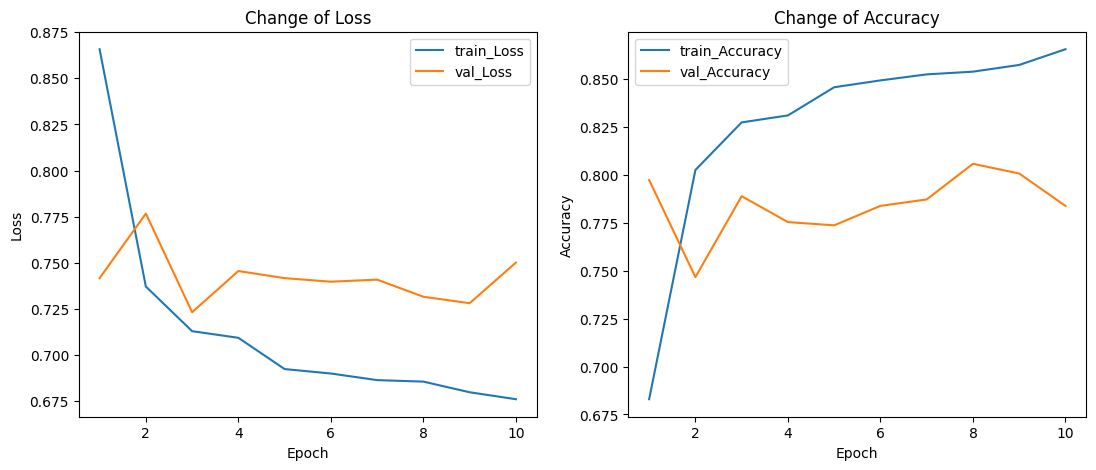

In [13]:
fig, axs = plt.subplots(1,2,figsize=(13,5))

def plot_log(ax, train_value, val_value, label):
    sns.lineplot(y=train_value,x=range(1,hyperparameter['epochs']+1),ax=ax,label=f'train_{label}')
    sns.lineplot(y=val_value,x=range(1,hyperparameter['epochs']+1),ax=ax,label=f'val_{label}')
    ax.set_title(f'Change of {label}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    
plot_log(axs[0],log.train_loss,log.val_loss,'Loss')
plot_log(axs[1],log.train_accuracy,log.val_accuracy,'Accuracy')

# Model Evaluation

In [14]:
device = hyperparameter['device']
model = SentimentClassifier(hyperparameter['num_classes'])
model.load_state_dict(torch.load('./best.pth'))
model.to(device)
model.eval()
labels = []
predictions = []

In [15]:
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        targets = batch['targets']

        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)    
        preds = torch.argmax(outputs, dim=1)
        preds_list = [pred.item() for pred in preds]
        labels_list = [label.item() for label in targets]

        labels.extend(labels_list)
        predictions.extend(preds_list)

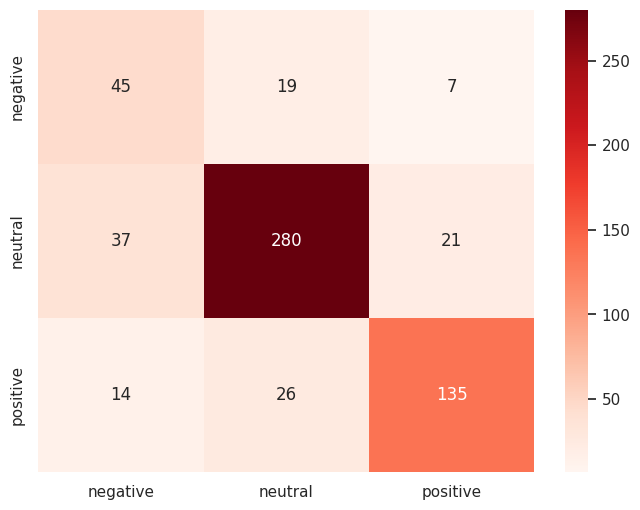

In [16]:
# visualize predictions
sns.set_theme(style='whitegrid',rc={'figure.figsize':(8,6)})
cf_matrix = confusion_matrix(labels, predictions)
sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [17]:
label_preds = encoder.inverse_transform(predictions)
label_targets = encoder.inverse_transform(labels)

print(classification_report(label_targets,label_preds))

              precision    recall  f1-score   support

    negative       0.47      0.63      0.54        71
     neutral       0.86      0.83      0.84       338
    positive       0.83      0.77      0.80       175

    accuracy                           0.79       584
   macro avg       0.72      0.74      0.73       584
weighted avg       0.80      0.79      0.79       584



In [18]:
# Predict sentiment for new data
new_sentences = ["the company's robust earnings have significantly boosted investor confidence",
                 "the firm's deteriorating cash flow has caused its stock to plummet",
                 "Solomon has had cereals for breakfast"]
def encode(sentence):
    encoding = tokenizer.encode_plus(sentence,
                          max_length=hyperparameter['max_len'],
                          add_special_tokens=True,
                          padding='max_length',
                          truncation=True,
                          return_attention_mask=True,
                          return_token_type_ids=False,
                          return_tensors='pt')
    return {
        'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
        'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
    }


encodings = [encode(sentence) for sentence in new_sentences]

ids = torch.stack([i['input_ids'] for i in encodings])
masks = torch.stack([i['attention_mask'] for i in encodings])
ids = ids.to(device, non_blocking=True).long()
masks = masks.to(device, non_blocking=True).long()

outputs = model(input_ids=ids, attention_mask=masks)
preds = torch.argmax(outputs, dim=1)
preds_list = [pred.item() for pred in preds]

label_preds = encoder.inverse_transform(preds_list)
for i in range(len(new_sentences)): 
    print(f"{new_sentences[i]} - {label_preds[i]}")

the company's robust earnings have significantly boosted investor confidence - positive
the firm's deteriorating cash flow has caused its stock to plummet - negative
Solomon has had cereals for breakfast - neutral
